In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

In [3]:
# Load the configuration file
with open('mmitss-monitor-rsu-config.json', 'r') as file:
    config = json.load(file)

log_directory = config['LogDirectory']
time_index = config['TimeIndex']
plot_directory = config['PlotDirectory']

file_paths = [os.path.join(log_directory, f) for f in os.listdir(log_directory) if time_index in f]

file_paths

['logs_test/Ellsworth_StoneSchool_04052024_000000/Ellsworth_StoneSchool_msgCountsLog_04052024_000000.csv',
 'logs_test/Ellsworth_StoneSchool_04052024_000000/Ellsworth_StoneSchool_spatLog_04052024_000000.csv',
 'logs_test/Ellsworth_StoneSchool_04052024_000000/.~lock.Ellsworth_StoneSchool_msgCountsLog_04052024_000000.csv#',
 'logs_test/Ellsworth_StoneSchool_04052024_000000/Ellsworth_StoneSchool_ssmLog_04052024_000000.csv',
 'logs_test/Ellsworth_StoneSchool_04052024_000000/Ellsworth_StoneSchool_remoteBsmLog_04052024_000000.csv',
 'logs_test/Ellsworth_StoneSchool_04052024_000000/Ellsworth_StoneSchool_srmLog_04052024_000000.csv']

In [4]:
# Define the possible timestamp columns
timestamp_columns = ['log_timestamp_verbose', 'log_timestamp_posix', 'timestamp_verbose', 'timestamp_posix']

def load_and_sort_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Find the timestamp column that exists in this DataFrame
    for timestamp in timestamp_columns:
        if timestamp in df.columns:
            # Convert timestamp to datetime if it's in a verbose format
            if 'verbose' in timestamp:
                df[timestamp] = pd.to_datetime(df[timestamp])
            # Sort the DataFrame based on the timestamp
            df = df.sort_values(by=timestamp)
            break

    return df

# Load and sort each file
dataframes = [load_and_sort_csv(path) for path in file_paths]

# Now you have a list of DataFrames, sorted by their respective timestamp columns


In [5]:
print (dataframes)

[          log_timestamp_verbose  log_timestamp_posix        timestamp_verbose  \
0    2024-04-05 00:00:08.011204         1.712290e+09   2024-04-05 04:00:08.11   
1    2024-04-05 00:04:35.090083         1.712290e+09   2024-04-05 04:04:35.89   
2    2024-04-05 00:04:35.090117         1.712290e+09   2024-04-05 04:04:35.90   
3    2024-04-05 00:04:35.090132         1.712290e+09   2024-04-05 04:04:35.90   
4    2024-04-05 00:05:08.811373         1.712290e+09  2024-04-05 04:05:08.811   
...                         ...                  ...                      ...   
1419 2024-04-05 23:58:10.987287         1.712376e+09  2024-04-06 03:58:10.987   
1420 2024-04-05 23:58:30.966027         1.712376e+09  2024-04-06 03:58:30.965   
1421 2024-04-05 23:59:35.096389         1.712376e+09   2024-04-06 03:59:35.96   
1422 2024-04-05 23:59:35.096423         1.712376e+09   2024-04-06 03:59:35.96   
1423 2024-04-05 23:59:35.096437         1.712376e+09   2024-04-06 03:59:35.96   

      timestamp_posix  int

In [6]:
# # The list of message types corresponding to the dataframes from index 1 to 4
# # message_types = ['srm', 'spat', 'ssm', 'bsm']

# message_types = ['ssm', 'bsm', 'srm']  # 'spat' is removed

# # Initialize a dictionary to store message counts per 10 minutes
# message_counts_per_10min = {msg: [] for msg in message_types}

# # Iterate over the message types and corresponding dataframes
# for msg_type, df in zip(message_types, [dataframes[2], dataframes[3], dataframes[4]]):
#     # Find the verbose timestamp column and convert to datetime if necessary
#     timestamp_col = df.columns[df.columns.str.contains('verbose')][0]
#     df[timestamp_col] = pd.to_datetime(df[timestamp_col])

#     # Set the datetime column as the DataFrame index
#     df.set_index(timestamp_col, inplace=True)

#     # Ensure the index is now a DatetimeIndex
#     if not isinstance(df.index, pd.DatetimeIndex):
#         df.index = pd.to_datetime(df.index)

#     # Group by 10-minute intervals and count the entries
#     ten_minute_counts = df.resample('10T').size()
#     message_counts_per_10min[msg_type] = ten_minute_counts

# # Combine the dataframes for plotting
# combined_df = pd.DataFrame(message_counts_per_10min)

# # Plotting
# combined_df.plot(kind='bar', width=0.8)
# plt.title('10-Minute Distribution of Messages (Excluding SPAT)')
# plt.xlabel('Time (10-minute intervals)')
# plt.ylabel('Number of Messages')
# plt.xticks(rotation=45)
# plt.legend(title='Message Type')
# plt.tight_layout()
# plt.show()

### Read from msgcount file

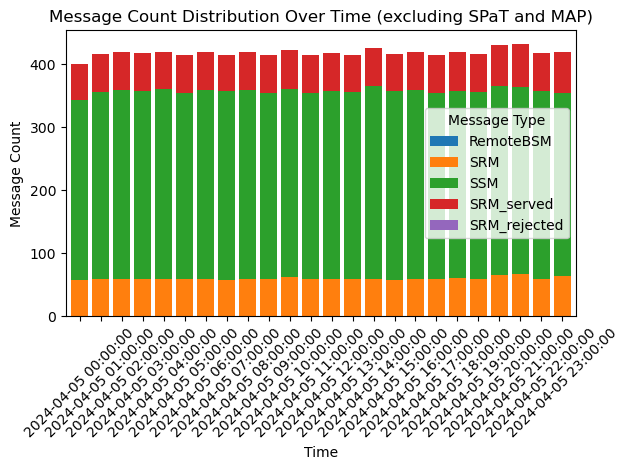

In [20]:
# Assuming `dataframes[0]` contains the summary data
df_summary = dataframes[0]
df_replace = df_summary.copy(deep=True)
df_summary = df_replace

time_period_str = 'H'


# Replace 'NA' with zeros in 'msg_count', 'msg_served', and 'msg_rejected', and convert to integer
df_summary['msg_count'] = pd.to_numeric(df_summary['msg_count'], errors='coerce').fillna(0).astype(int)
df_summary['msg_served'] = pd.to_numeric(df_summary['msg_served'], errors='coerce').fillna(0).astype(int)
df_summary['msg_rejected'] = pd.to_numeric(df_summary['msg_rejected'], errors='coerce').fillna(0).astype(int)

# Convert the 'log_timestamp_verbose' to datetime
df_summary['log_timestamp_verbose'] = pd.to_datetime(df_summary['log_timestamp_verbose'])

# Set the 'log_timestamp_verbose' as the index
df_summary.set_index('log_timestamp_verbose', inplace=True)

# Filter out 'SPaT' and 'MAP' messages
df_filtered = df_summary[~df_summary['msg_type'].isin(['SPaT', 'MAP'])]

# Group by msg_type and resample to aggregate counts over each 10-minute interval
# We pivot immediately after resampling, within the same groupby operation
df_grouped = df_filtered.groupby('msg_type').resample(time_period_str).agg({'msg_count': 'sum'})

# Pivot the table to get msg_type as columns and fill NaN with 0s
df_pivot = df_grouped.pivot_table(index=df_grouped.index.get_level_values(1), 
                                  columns='msg_type', 
                                  values='msg_count', 
                                  fill_value=0)

# For SRM messages, we want to separate served and rejected counts
srm_served = df_filtered[df_filtered['msg_type'] == 'SRM'].resample(time_period_str)['msg_served'].sum().rename('SRM_served')
srm_rejected = df_filtered[df_filtered['msg_type'] == 'SRM'].resample(time_period_str)['msg_rejected'].sum().rename('SRM_rejected')

# Combine with the existing pivot table
df_pivot = pd.concat([df_pivot, srm_served, srm_rejected], axis=1)

# Plotting
# df_pivot.plot(kind='bar', stacked=True, width
df_pivot.plot(kind='bar', stacked=True, width=0.8)
plt.title('Message Count Distribution Over Time (excluding SPaT and MAP)')
plt.xlabel('Time')
plt.ylabel('Message Count')
plt.xticks(rotation=45)
plt.legend(title='Message Type')
plt.tight_layout()
plt.show()

In [16]:
print("Column names in dataframe:", df_summary.columns)


Column names in dataframe: Index(['log_timestamp_posix', 'timestamp_verbose', 'timestamp_posix',
       'interval_sec', 'msg_source', 'msg_type', 'msg_count', 'msg_served',
       'msg_rejected'],
      dtype='object')
